In [7]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle

In [8]:
X = np.load('bottleneck.npy')
y = np.load('segmented.npy')

In [9]:
print(X.shape, y.shape)

(2000, 14, 19, 8) (2000, 64, 84, 10)


In [10]:
#Shuffle
X,y = shuffle(X,y)

X = X.astype(np.float32)
y = y.astype(np.float32)

In [11]:
# Normalize
X -= 127.0
X /= 127.0

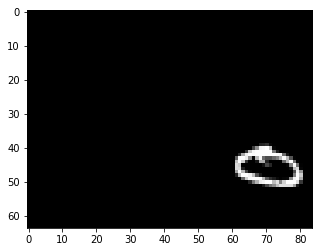

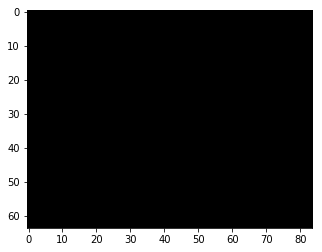

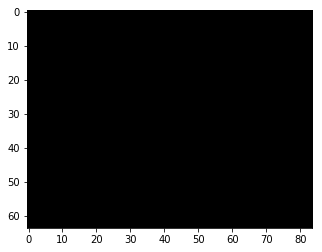

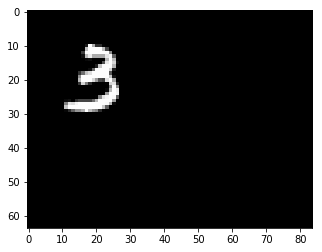

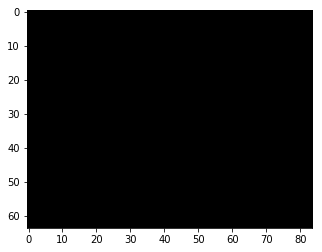

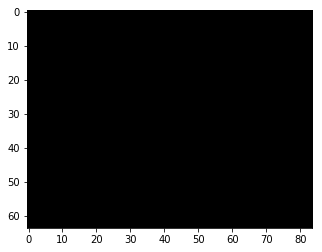

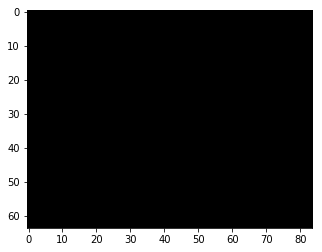

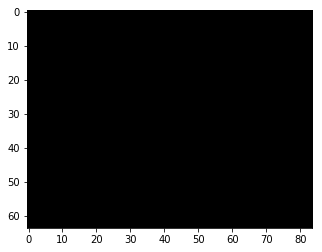

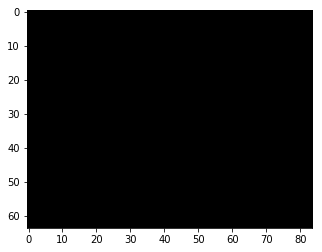

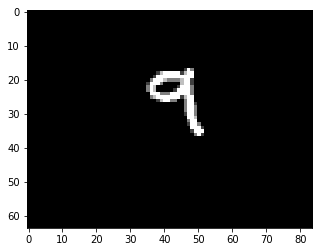

In [12]:
rand_index = np.random.randint(0,len(y))
c,s = X[rand_index], y[rand_index]

## X data is bottleneck features, not image.
# plt.imshow(c, cmap='gray')
# plt.show()

for i in range(10):
    plt.imshow(s[:,:,i],cmap='gray')
    plt.show()

In [13]:
# Split it into train and validation
n_train = int(0.7 * len(y))

y_train, X_train, y_test, X_test = y[: n_train], X[: n_train, :], y[n_train:], X[n_train:, :]


In [14]:
def get_next_batch(batch_size, X, y):
    for start in range(0,len(y),batch_size):
        end = min(len(y), start+batch_size)
        yield X[start:end] , y[start:end]

In [15]:
num_classes = 10

In [22]:
from tensorflow.core.framework import graph_pb2
graph_def = graph_pb2.GraphDef()

In [23]:
def load_graph(path_protobuf):
    with open(path_protobuf, "rb") as f:
        graph_def.ParseFromString(f.read())
        with tf.Graph().as_default() as graph:
            # Createa new placeholder
            input_big = tf.placeholder(dtype=tf.float32, shape=(None, 64,84,1), name='input_image_big')
            # Import the graph and replace the reshape node with new placeholder.
            tf.import_graph_def(graph_def, name="", input_map={"reshaped_image": input_big})
            return graph

In [170]:
# def nn(nb_classes):
#     bottleneck_placeholder = tf.placeholder(dtype=tf.float32, shape=(None, X.shape[1],X.shape[2],1), name='input_bottleneck')
#     labels = tf.placeholder(dtype=tf.int32, shape=(None, y.shape[1], y.shape[2], y.shape[3]), name='segmentation_labels')
#     learning_rate_ph = tf.placeholder(dtype=tf.float32, name='learning_rate')
    
    
#     _conv1x1 = lambda tensor , nb_classes :\
#      tf.layers.conv2d(tensor, 
#                     nb_classes, 
#                     1, 
#                     1, 
#                     padding='same',
#                     kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
        
#     _upsample = lambda tensor, kernel_sz, stride,nb_classes :\
#      tf.layers.conv2d_transpose(tensor, 
#                                 nb_classes, 
#                                 kernel_sz, 
#                                 stride, 
#                                 padding='valid',
#                                 kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
#     encoder=load_graph('./checkpoints/frozen_graph.pb')
#     with encoder .as_default():
#         input_ph=encoder.get_tensor_by_name('input_image_big:0')
#         maxpool1_out=encoder.get_tensor_by_name('pool1/MaxPool:0')
#         maxpool2_out=encoder.get_tensor_by_name('poool2/MaxPool:0')
#         conv32 = tf.layers.conv2d(maxpool2_out,32,1)
#         output=tf.layers.conv2d(conv32,10,1)
#         l1 = _upsample(output,4,2,10)
#         l2 = _upsample(l1,6,2,10)
    
#         prediction = tf.identity(tf.nn.softmax(l2), name='prediction')
#         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=l2, labels=tf.one_hot(labels,depth=10)), name='cost')
    
#     # Apply an optimizer
#         optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_ph).minimize(cost)
    
# #     cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits)
    
#     return l2
def nn(nb_filters):
    encoder = load_graph('./checkpoints/frozen_graph.pb')
    with encoder.as_default():
        input_ph = encoder.get_tensor_by_name('input_image_big:0')
        maxpool1_out = encoder.get_tensor_by_name('pool1/MaxPool:0')
        maxpool2_out = encoder.get_tensor_by_name('poool2/MaxPool:0')


        #print(conv32.shape)

        bottleneck_placeholder = tf.placeholder(dtype=tf.float32, shape=(None, X.shape[1],X.shape[2],1), name='input_bottleneck')
        labels = tf.placeholder(dtype=tf.int32, shape=(None, y.shape[1], y.shape[2], y.shape[3]), name='segmentation_labels')
        learning_rate_ph = tf.placeholder(dtype=tf.float32, name='learning_rate')


        _conv1x1 = lambda tensor,nb_filters :\
        tf.layers.conv2d(tensor,
                      nb_filters,
                      1,
                      1,
                      padding='same',
                      kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))

        _upsample = lambda tensor, kernel_sz, stride, nb_filters :\
        tf.layers.conv2d_transpose(tensor,
                                  nb_filters,
                                  kernel_sz,
                                  stride,
                                  padding='valid',
                                  kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
        conv32 = tf.layers.conv2d(maxpool2_out,32,1,name='conv32')
        conv10 = tf.layers.conv2d(conv32,10,1)

        temp=tf.layers.conv2d(maxpool1_out,10,1)
        
        l1 = _upsample(conv10,4,2,10)
#         l2 = _upsample(l1,6,2,10)
        l2=tf.add(l1,temp)
        l2 = _upsample(l1,6,2,10)
        prediction = tf.identity(tf.nn.softmax(l2), name='prediction')
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=l2, labels=tf.one_hot(labels,depth=10)), name='cost')

        # Apply an optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_ph).minimize(cost)

    return l2

In [171]:
cost = nn(10)

In [172]:
print(cost.shape)

(?, 64, 84, 10)


In [173]:
def eval_cost(cost_op, X, y, batch_sz):
    total_cost = 0
    nb_batches = 0
    for batch_X,batch_y in get_next_batch(batch_size,X,y):
        feed_dict={img_placeholder: batch_X, labels: batch_y}
        total_cost += cost.eval(feed_dict=feed_dict)
        nb_batches += 1
    return total_cost / nb_batches

def eval_accuracy(output_op, X, y, batch_sz):
    nb_batches = 0
    total_acc = 0
    for batch_X, batch_y in get_next_batch(batch_sz,X,y):
        feed_dict={img_placeholder: batch_X, labels: batch_y}
        y_predicted = np.argmax(output.eval(feed_dict=feed_dict),1)
        total_acc += accuracy_score(batch_y,y_predicted)
        nb_batches += 1
    return 100*total_acc/nb_batches

In [174]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

epochs = 75
batch_size = 512
learning_rate = 0.001
batches_per_epoch = int(X_train.shape[0]/batch_size)
n_train = int(len(y_train)*0.8)



# Launch the graph
with tf.Session() as sess:
    summary_writer = tf.summary.FileWriter('./',sess.graph)
    
    sess.run(tf.global_variables_initializer())
    
    for epoch in tqdm(range(epochs)):
        # Shuffle data for cross validation
        indices = np.array(range(len(y_train)))
        np.random.shuffle(indices)
        
        train_indices = indices[: n_train]
        val_indices = indices[n_train:]
        

        
        y_train_fold, X_train_fold, y_val_fold, X_val_fold = y_train[train_indices], X_train[train_indices, :], \
        y_train[val_indices], X_train[val_indices, :]
        
        # Loop over all training batches
        for x, y in get_next_batch(batch_size, X_train_fold, y_train_fold):
            sess.run(optimizer, 
                     feed_dict={img_placeholder:x, labels:y, learning_rate_ph:learning_rate})
        
        if (epoch+1) % 5 == 0:
            training_cost = eval_cost(cost, X_train_fold, y_train_fold, batch_size)
            training_acc  = eval_accuracy(output, X_train_fold, y_train_fold, batch_size)
            valid_acc  = eval_accuracy(output, X_val_fold, y_val_fold, batch_size)
            test_acc  = eval_accuracy(output, X_test, y_test, batch_size)
            #print(training_cost, training_acc, valid_acc, test_acc)
            
            summary = tf.Summary()
            summary.value.add(tag="Train Cost", simple_value=training_cost)
            summary.value.add(tag="Train Accuracy", simple_value=training_acc)
            summary.value.add(tag="Validation Accuracy", simple_value=valid_acc)
            summary.value.add(tag="Test Accuracy", simple_value=test_acc)
            summary_writer.add_summary(summary,epoch+1)
            summary_writer.flush()

    
    print("Optimization Finished!")
    summary_writer.close()
    # Save the graph structure only.
    # Need to save weights in a checkpoint file separately.
    # The graph structure is saved twice, once as a text file 
    # with extension '.pbtxt' and then as a binary file with 
    # extension '.pb'. This is done for demonstration only.
    tf.train.write_graph(
    tf.get_default_graph().as_graph_def(),
    './checkpoints/',
    'mnist.pbtxt',
    as_text=True)
    
    tf.train.write_graph(
    tf.get_default_graph().as_graph_def(),
    './checkpoints/',
    'mnist.pb',
    as_text=False)
    
    saver = tf.train.Saver()
    saver.save(sess,'./checkpoints/mnist.ckpt',epoch+1)

  0%|                                                                                           | 0/75 [00:00<?, ?it/s]


NameError: name 'optimizer' is not defined